# Tidal melting analysis
Import tidal analysis routine and load roms data (30 days of hourly melt rates).

In [1]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

from features.grid_ttide import grid_ttide
%aimport features.grid_ttide

In [2]:
his_path = os.path.join(os.environ.get('rawdir'),'waom10','ocean_his_hourly_0007.nc')
rds = xr.open_dataset(his_path,chunks={'xi_rho':100,'eta_rho':100})

Select single ice shelf (FRIS) for testing.

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


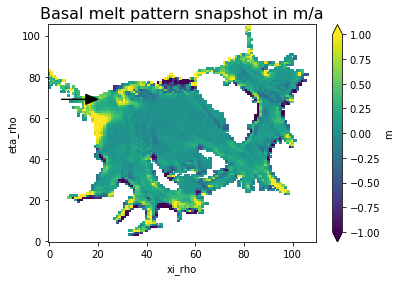

In [48]:
s2a = 3600*24*365
FRIS = rds.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))
FRIS['m'] *= s2a

plt.close()
FRIS.where((FRIS.mask_rho==1) & (FRIS.zice<0.0)).m[0].plot(vmin=-1,vmax=1)
plt.title('Basal melt pattern snapshot in m/a',fontsize=16)
ax = plt.axes()
ax.arrow(5, 69, 10, 0.0, head_width=5, head_length=5, fc='k', ec='k')
plt.show()

## Analysis of single cell melt signal from the ice shelf front

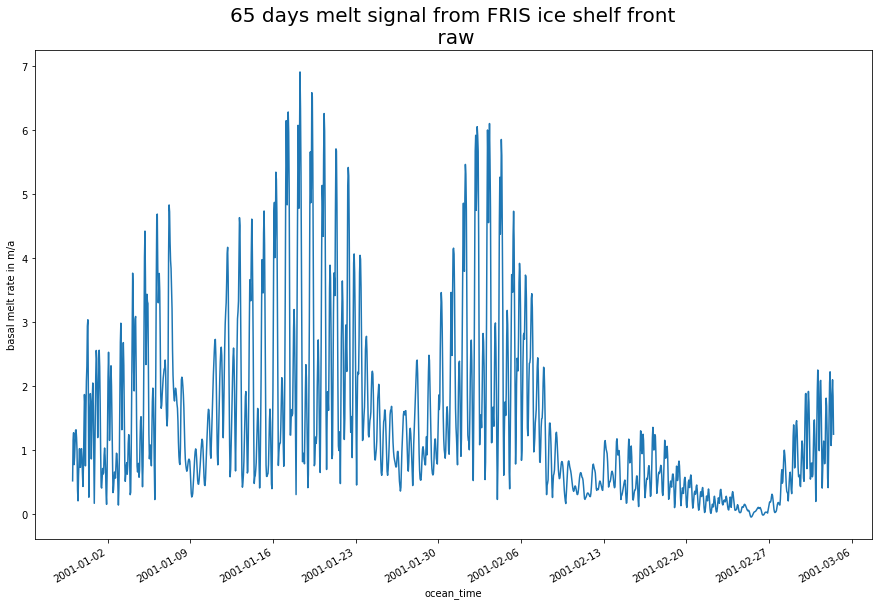

In [13]:
signal = FRIS.isel(eta_rho=69,xi_rho=15).m
plt.close()
signal.plot(size=10)
plt.title("65 days melt signal from FRIS ice shelf front\n raw",fontsize=20)
plt.ylabel('basal melt rate in m/a')
plt.show()

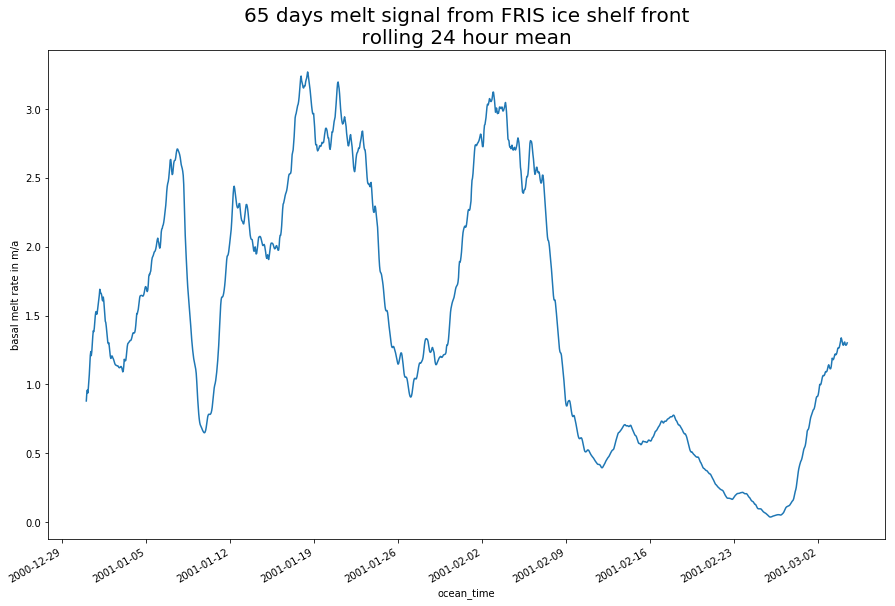

In [12]:
daily_rolling_mean = signal.rolling(ocean_time=24).mean()
plt.close()
daily_rolling_mean.plot(size=10)
plt.title("65 days melt signal from FRIS ice shelf front\n rolling 24 hour mean ",fontsize=20)
plt.ylabel('basal melt rate in m/a')
plt.show()

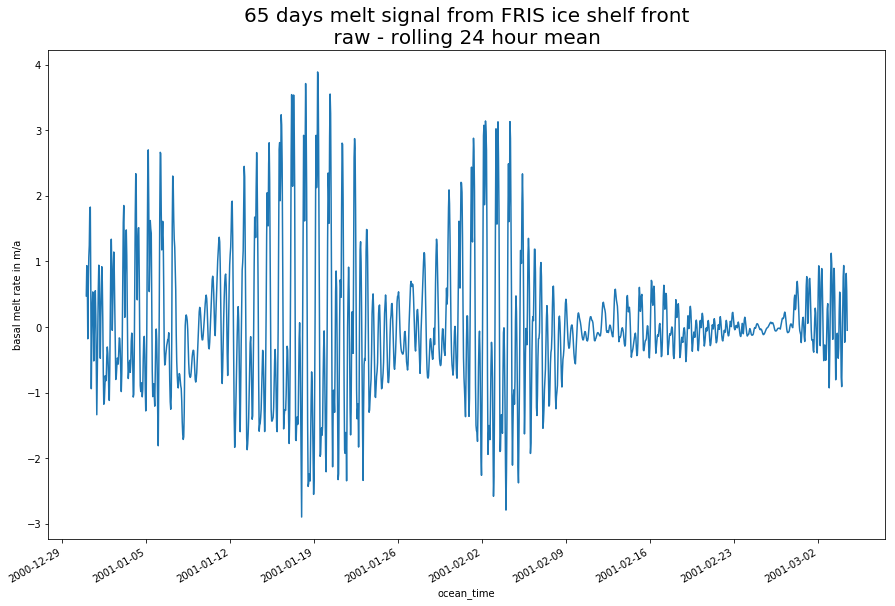

In [14]:
direct_tidal_melt = signal - daily_rolling_mean
plt.close()
direct_tidal_melt.plot(size=10)
plt.title("65 days melt signal from FRIS ice shelf front\n raw - rolling 24 hour mean ",fontsize=20)
plt.ylabel('basal melt rate in m/a')
plt.show()

### Average of direct tidal melt signal

In [22]:
print("65 day verage of direct tidal melt signal: %.4f" %direct_tidal_melt.mean('ocean_time').values,'m/a')

65 day verage of direct tidal melt signal: 0.0051 m/a


### Tidal analysis of raw melt signal

In [31]:
import ttide as tt
import pandas as pd
stime=pd.to_datetime(signal.ocean_time[0].values)
lat=signal.lat_rho.values
print(stime,lat)
tt_out = tt.t_tide(signal.values,stime=stime,lat=lat)

2000-12-30 01:00:00 -74.9228967272284
-----------------------------------
nobs = 1547 
ngood = 1547 
record length (days) = 64.46
start time: 2000-12-30 00:59:59
rayleigh criterion = 1.0

Greenwich phase computed with nodal
                   corrections applied to amplitude
                   and phase relative to center time

x0= 1.46  xtrend= 0
var(data)= 1.74    var(prediction)= 0.55    var(residual)= 1.24
var(prediction)/var(data) (%) = 31.7

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  MM    0.0015122     0.4021     0.644     12.26    115.19      0.39
  MSF   0.0028219     0.6431     0.716    244.59     74.49      0.81
  ALP1  0.0343966     0.0427     0.196    346.38    202.28     0.048
  2Q1   0.0357064     0.1270     0.262    305.63    110.13      0.24
  Q1    0.0372185     0.1051     0.204    240.40    124.62      0.27
* O1    0.0387307     0.4636     0.241    229.09     31.13       3.7
  NO1   0.0

## Analysis of example area of ice shelf

In [81]:
FRIS_sel = FRIS.isel(eta_rho=slice(50,80),xi_rho=slice(10,40))
shelf_m = FRIS_sel.m.where((FRIS_sel.mask_rho==1) & (FRIS_sel.zice<0.0))
tt_out_shelf = grid_ttide(shelf_m,FRIS_sel,res=30,constit_list=['O1','M2','K1','S2'])

setting up the new fields  ['amp', 'amp_err', 'phase', 'phase_err']  for  ['O1', 'M2', 'K1', 'S2']
applying t_tide to every  30 th cell ...


VBox(children=(HTML(value=''), IntProgress(value=0, max=30)))

No predictions with this SNR
interpolating intermediate cells and mask land


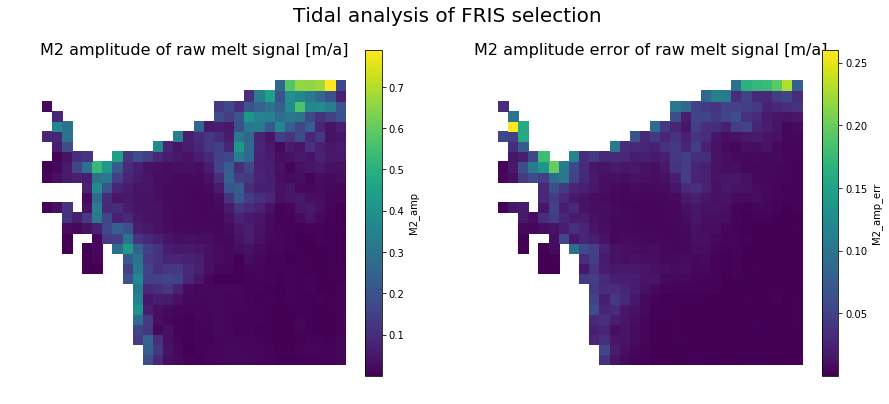

In [82]:
plt.close()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Tidal analysis of FRIS selection\n ',fontsize=20)
tt_out_shelf.where((FRIS_sel.mask_rho==1) & (FRIS_sel.zice<0.0)).M2_amp.plot(ax=ax1)
ax1.set_title('M2 amplitude of raw melt signal [m/a]',fontsize=16)
tt_out_shelf.where((FRIS_sel.mask_rho==1) & (FRIS_sel.zice<0.0)).M2_amp_err.plot(ax=ax2)
ax2.set_title('M2 amplitude error of raw melt signal [m/a]',fontsize=16)

for ax in [ax1,ax2]:
    ax.set_aspect('equal')
    ax.axis('off')
plt.show()